## Step 1: Load the newsgroups data

The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. You can find additional information here:

In [ ]:
import warnings
# Ignoring such warnings can make the output cleaner, I wantt to get rid of the init warnings.
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
from sklearn.datasets import fetch_20newsgroups

# You can load just a subset of categories for simplicity
categories = ['talk.religion.misc','alt.atheism','soc.religion.christian']

# Load the training data
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)

# Example of accessing the data
print(newsgroups_train.data[0])
print(newsgroups_train.target[0])  # Corresponding target to the above document

# The size of the dataset can be found by checking the length of the data list
print(f"Training set size: {len(newsgroups_train.data)}")

From: jayne@mmalt.guild.org (Jayne Kulikauskas)
Subject: Re: Can sin "block" our prayers?
Organization: Kulikauskas home
Lines: 27

mike@boulder.snsc.unr.edu (Mike McCormick) writes:

> Not honoring our wives can cause our prayers to be hindered:
> 
>         You husbands likewise, live with your wives in
>         an understanding way, as with a weaker vessel,
>         since she is a woman;  and grant her honor as
>         a fellow heir of the grace of life, so that your
>         prayers may not be hindered.  I Peter 3:7

One interpretation I've heard of this verse is that it refers to the sin 
of physically abusing one's wife.  The husband is usually physically 
stronger than his wife but is not permitted to use this to dominate her.  
He must honor her as his sister in Christ.  This would therefore be an 
example of a specific sin that blocks prayer.

This verse also makes me think of the kind of husband who decides what 
is God's will for his family without consulting his wife. 

## Step 2:  Vectorize our data

We need to turn our text into sets of words.  However, we don't want words that are either too frequent or infrequent.  To do this, we'll use the TF-IDF vectorizer, and pick the top N (up to you!) words.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Sample data
documents = newsgroups_train.data

# Initialize the TFIDF vectorizer
vectorizer = TfidfVectorizer(stop_words="english")

# Fit the model and transform the documents
tfidf_matrix = vectorizer.fit_transform(documents)

print(vectorizer)

# Get the feature names
feature_names = vectorizer.get_feature_names_out()

# Get the TF-IDF scores for each feature
# Here, we sum the scores for each term across all documents
sums = tfidf_matrix.sum(axis=0)

# Connecting term to its sums score
data = []
for col, term in enumerate(feature_names):
    data.append((term, sums[0,col]))

# Create a DataFrame with the terms and their scores
ranking = pd.DataFrame(data, columns=['term','rank'])
ranking = ranking.sort_values('rank', ascending=False)

# Select top N terms
top_n = 1000
top_n_terms = ranking.head(top_n)
print(top_n_terms)

TfidfVectorizer(stop_words='english')
            term       rank
8230         edu  54.141299
10292        god  50.703659
5671         com  36.943917
16372     people  31.206464
12551      jesus  27.993130
...          ...        ...
8898    examples   2.508613
18289    related   2.506292
17433   prophets   2.501462
9648   followers   2.498626
8576    entirely   2.497467

[1000 rows x 2 columns]


## Step 3: Join your terms with the Glove Vectors

The GLOVE vectors are word embeddings produced by the Word2Vec network model.  You can find them at the [Stanford GloVe repository](https://nlp.stanford.edu/projects/glove/).  You'll probably want the smallest one (glove6b).  Once you have them, you'll need to map these vectors to your data - note that the vectors come in different sizes.  I'll use the 100 dimension vectors here for demonstration purposes.

In [ ]:
import numpy as np

# Load GloVe vectors into a dictionary:
glove_vectors = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_vectors[word] = vector

In [ ]:
original_feature_names = top_n_terms.term

#Note that not all features are present in the glove vectors, so we'll filter here:
word_vectors = []
filtered_feature_names = []

for word in original_feature_names:
    if word in glove_vectors:
        word_vectors.append(glove_vectors[word])
        filtered_feature_names.append(word)

# Convert the list of vectors to a numpy array
word_vectors = np.array(word_vectors)

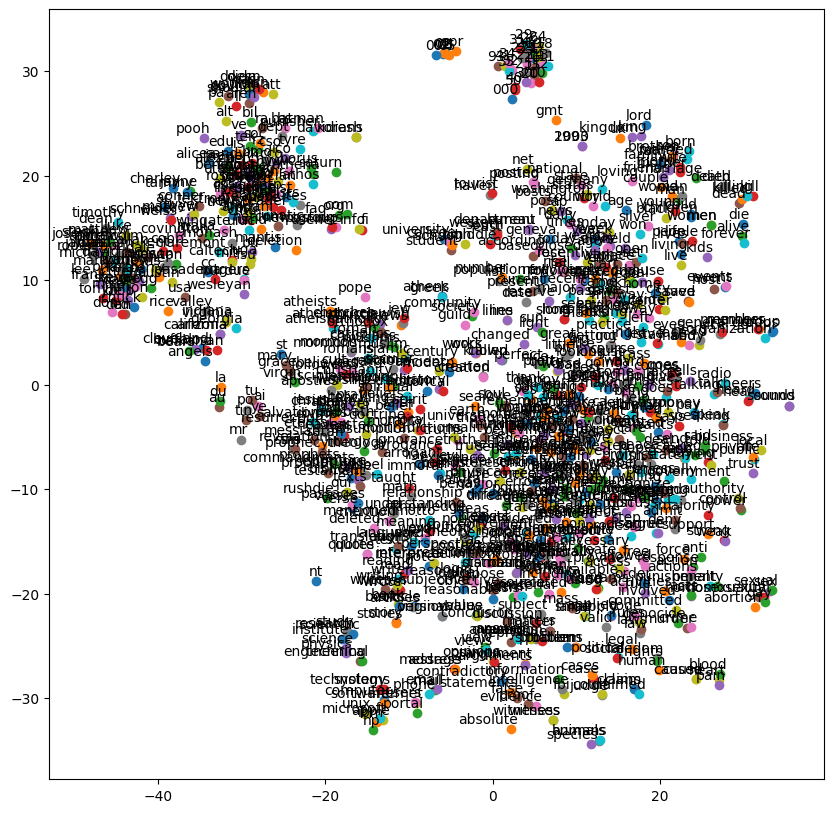

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Use t-SNE to project the vectors into a 2D space
tsne = TSNE(n_components=2)
word_vectors_2d = tsne.fit_transform(word_vectors)

# Plot the projection
plt.figure(figsize=(10, 10))
for i, word in enumerate(filtered_feature_names):
    if word in glove_vectors:  # Only plot words that were in the GloVe vectors
        plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1])
        plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom')
plt.show()

### Applying KMeans Clustering for Visualizing the Data Before and After Clustering

Following the t-SNE reduction, we apply KMeans clustering to identify three distinct clusters within the data. KMeans is chosen for its simplicity and effectiveness in forming clusters based on distance metrics. The number of clusters is set to three, aligning with the number of newsgroups we are analyzing, with the expectation that each cluster may correspond to one of the newsgroups.

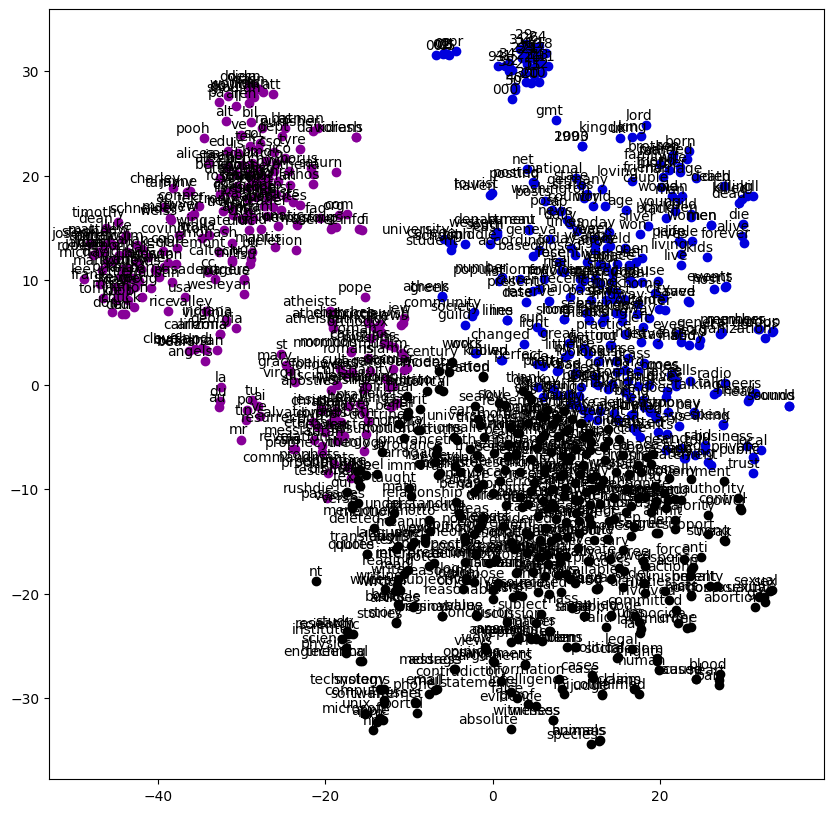

In [ ]:
from sklearn.cluster import KMeans

# Apply KMeans clustering to the t-SNE 2D word vectors
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(word_vectors_2d)

# Plot the t-SNE projection with the KMeans clusters
plt.figure(figsize=(10, 10))
for i, word in enumerate(filtered_feature_names):
    if word in glove_vectors:
        plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1], color=plt.cm.nipy_spectral(clusters[i] / 10.))
        plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom')
plt.show()


# What happens if you project the data before you cluster? What happens if you don't? Explain which you prefer and why?

## Before talking anything about the two projections
While the clustered visualization provides clear groupings of the data, I prefer to begin with the non-clustered t-SNE visualization. This approach allows us to visually discern subtle structures and patterns within the data that might not be immediately apparent through clustering. By exploring these nuances in the initial visualization, we can identify potentially significant aspects of the data that could inform and refine subsequent analytical steps.

## Observations from t-SNE Projection
The first plot shows the result of a t-SNE projection:
- The points are spread out, indicating some structure.
- However, the clusters are not clearly defined without clustering.

## Observations from KMeans Clustering
The second plot shows the result after applying KMeans clustering to the t-SNE reduced data:
- Data points are colored based on the clusters determined by KMeans.
- Clusters are now explicitly defined and distinguishable.

## Advantages of Projecting Before Clustering
- **Visualization**: Projected data can be visualized in 2D, offering intuitive insights.
- **Noise Reduction**: Techniques like t-SNE can separate clusters even in noisy data.
- **Computational Efficiency**: Lower dimensions can lead to faster clustering computations.

## Disadvantages
- **Distortion**: Dimensionality reduction can distort distances between data points.
- **Loss of Global Structure**: t-SNE focuses on local neighbors and may lose the global data distribution.

## Advantages of Not Projecting Before Clustering
- **Preservation of Structure**: Clustering in high-dimensional space retains all original information.
- **Global Relationships**: Some clustering algorithms may perform better with full data access.

## Conclusion
The choice depends on the goals and nature of the data:
- For datasets where local relationships are significant or when visualization is a priority, projecting before clustering is advantageous.
- If the global structure is essential, clustering in the original space may be preferable.

## Dimensionality Reduction Techniques

In our analysis, we employ two popular dimensionality reduction techniques, PCA and t-SNE, to transform our high-dimensional text data into a two-dimensional space suitable for visualization and further analysis.

### Principal Component Analysis (PCA)

PCA is a linear transformation technique that identifies the directions (principal components) along which the variance in the data is maximized. By projecting the data onto these directions, we reduce its dimensionality while attempting to preserve as much variance as possible.

### t-Distributed Stochastic Neighbor Embedding (t-SNE)

t-SNE, on the other hand, is a non-linear dimensionality reduction technique that is particularly effective at visualizing clusters in high-dimensional data. It works by modeling pairwise similarities in the high-dimensional space and seeking a low-dimensional representation that preserves these similarities.

In [ ]:
# PCA for dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
word_vectors_pca = pca.fit_transform(word_vectors)

# t-SNE for dimensionality reduction
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
word_vectors_tsne = tsne.fit_transform(word_vectors)


# Clustering Techniques and Visualization

After reducing the dimensionality of our text data, we now apply two clustering techniques: KMeans and Hierarchical Agglomerative Clustering (HAC). Each method has its own approach to grouping data, and we will apply both to our PCA and t-SNE reduced word vectors.

## KMeans Clustering

KMeans is a widely-used clustering algorithm that partitions the data into `k` distinct clusters. It does so by minimizing the variance within each cluster, effectively grouping data points that are close to each other.

## Hierarchical Agglomerative Clustering (HAC)

HAC is a different type of clustering that builds up clusters step by step. Starting with each data point as its own cluster, it merges the closest pairs of clusters until all points are merged into a single cluster. This process creates a hierarchy of clusters that can be useful for understanding data structure.

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters_kmeans_pca = kmeans.fit_predict(word_vectors_pca)
clusters_kmeans_tsne = kmeans.fit_predict(word_vectors_tsne)

# Hierarchical Agglomerative Clustering
hac = AgglomerativeClustering(n_clusters=3)
clusters_hac_pca = hac.fit_predict(word_vectors_pca)
clusters_hac_tsne = hac.fit_predict(word_vectors_tsne)

### Visualization of Clusters

With clusters determined, our next step is to visualize them. This visualization helps in understanding how data points are grouped and whether the clusters make intuitive sense.

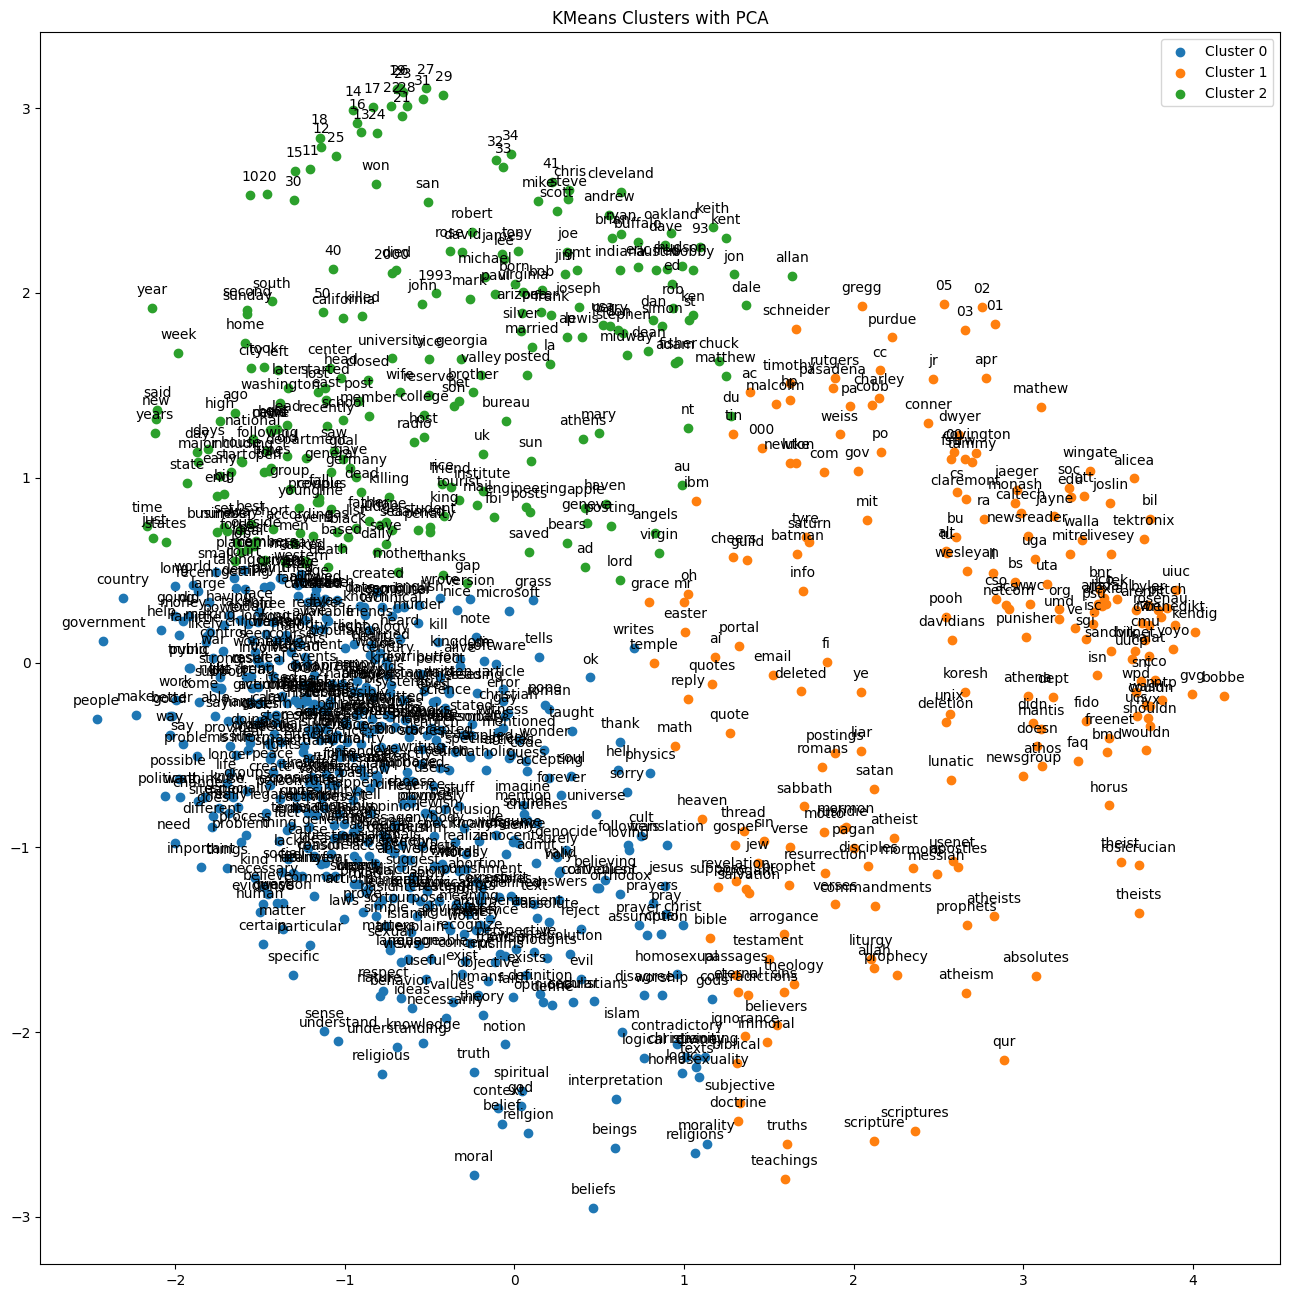

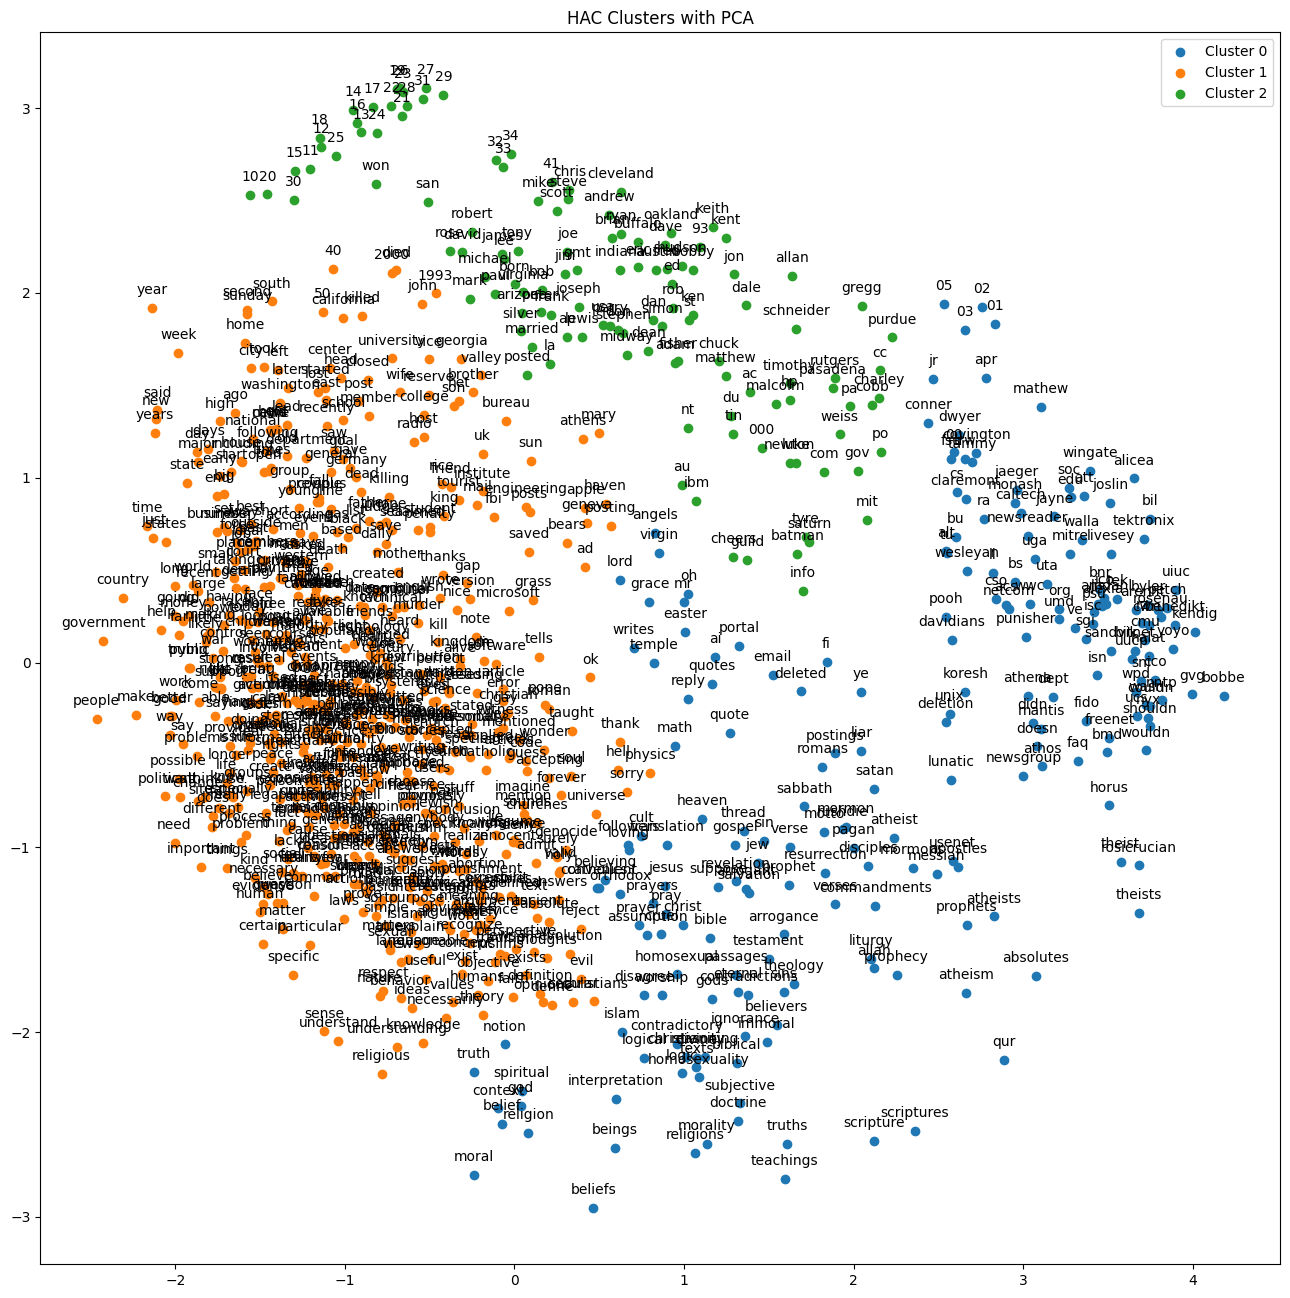

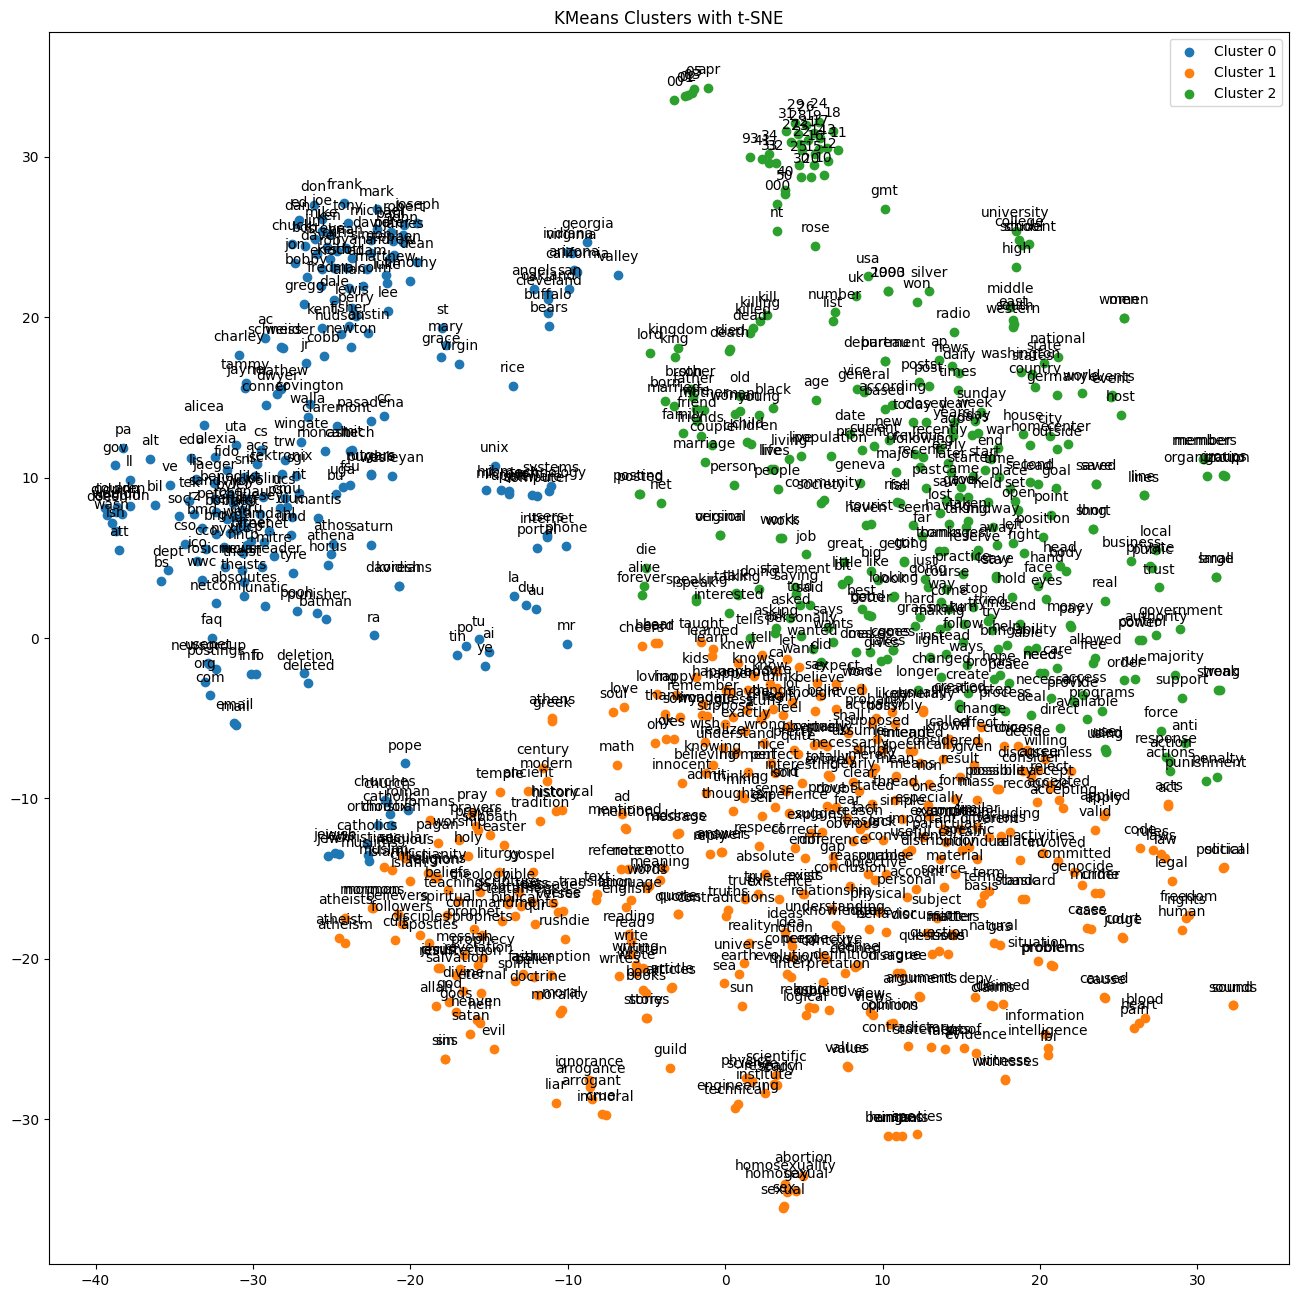

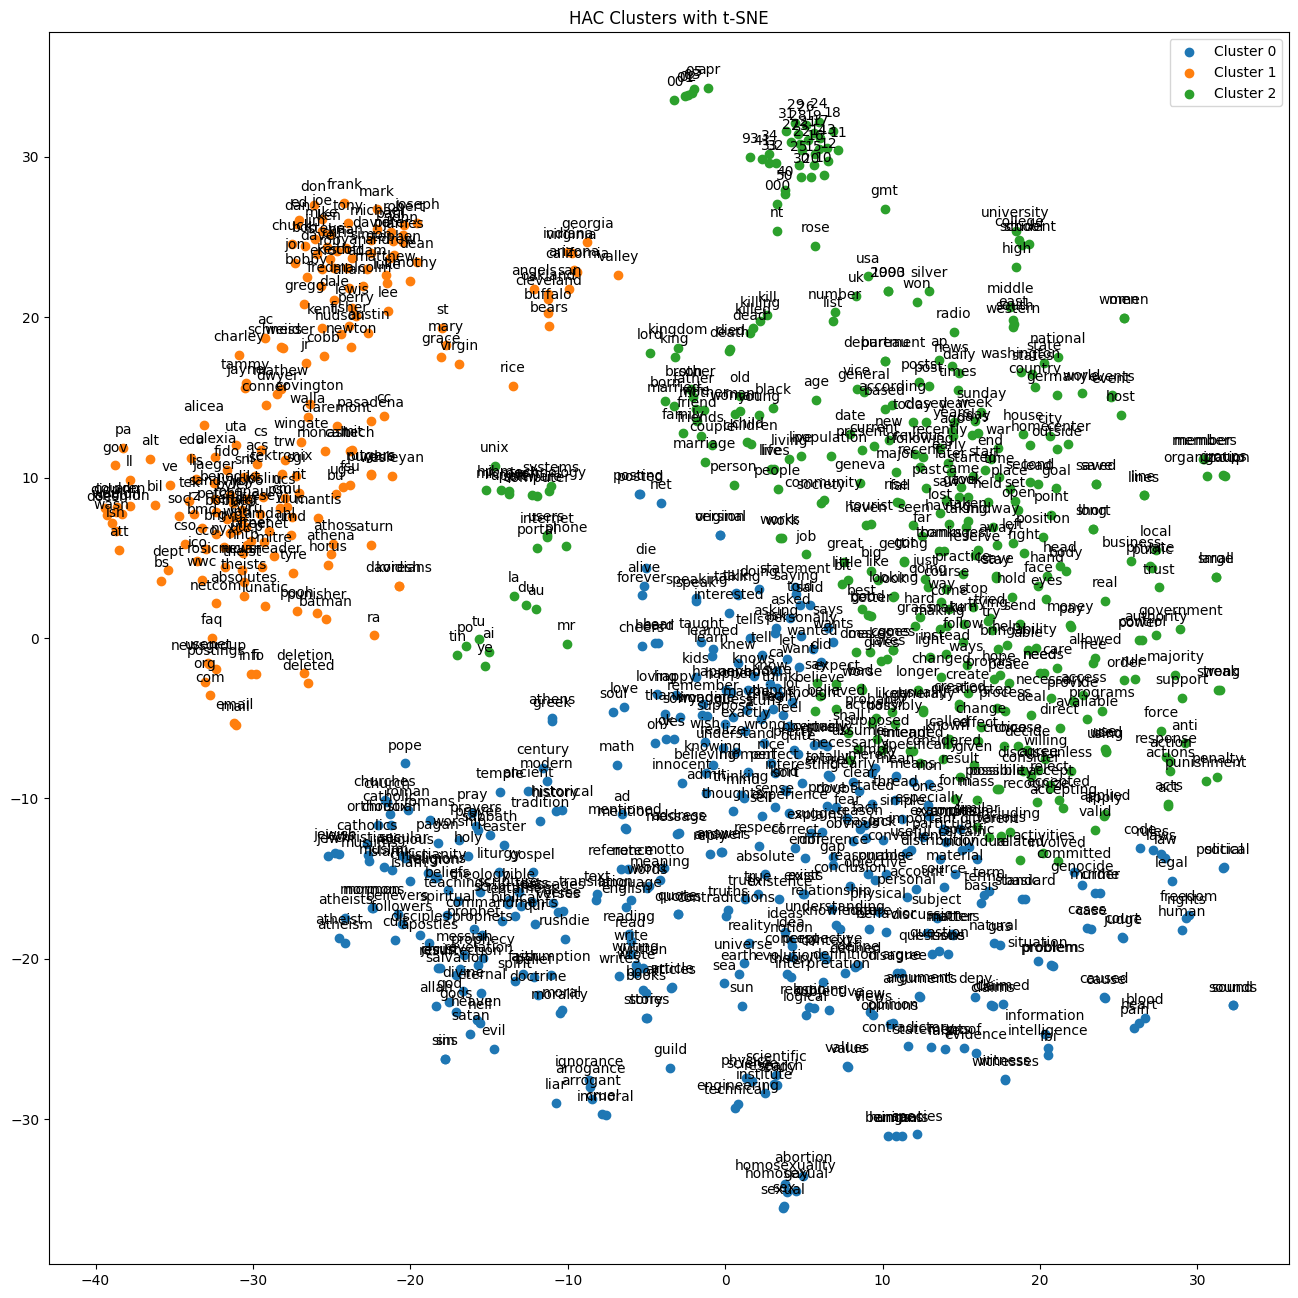

In [ ]:
import matplotlib.pyplot as plt

def plot_clusters(word_vectors, clusters, feature_names, title):
    plt.figure(figsize=(16, 16))
    plt.title(title)
    unique_clusters = set(clusters)
    for cluster in unique_clusters:
        cluster_idx = [i for i, c in enumerate(clusters) if c == cluster]
        cluster_points = word_vectors[cluster_idx, :]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
        for i, idx in enumerate(cluster_idx):
            # Check to ensure the index is within the bounds of feature_names
            if idx < len(feature_names):
                plt.annotate(feature_names[idx],
                             (cluster_points[i, 0], cluster_points[i, 1]),
                             textcoords='offset points', xytext=(0,10), ha='center')
    plt.legend()
    plt.show()

# Plotting KMeans clusters with PCA reduced data
plot_clusters(word_vectors_pca, clusters_kmeans_pca, filtered_feature_names, "KMeans Clusters with PCA")

# Plotting HAC clusters with PCA reduced data
plot_clusters(word_vectors_pca, clusters_hac_pca, filtered_feature_names, "HAC Clusters with PCA")

# Plotting KMeans clusters with t-SNE reduced data
plot_clusters(word_vectors_tsne, clusters_kmeans_tsne, filtered_feature_names, "KMeans Clusters with t-SNE")

# Plotting HAC clusters with t-SNE reduced data
plot_clusters(word_vectors_tsne, clusters_hac_tsne, filtered_feature_names, "HAC Clusters with t-SNE")

# Evaluating Clustering Performance with Silhouette Scores

To quantitatively assess the effectiveness of our clustering techniques, we use the silhouette score. This metric measures how similar an object is to its own cluster compared to other clusters. A high silhouette score indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters, with a score close to +1 indicating a very clear distinction.

## Calculation of Silhouette Scores

We calculate the silhouette scores for each combination of dimensionality reduction technique (PCA and t-SNE) and clustering method (KMeans and HAC)


In [ ]:
from sklearn.metrics import silhouette_score

# Silhouette scores
silhouette_kmeans_pca = silhouette_score(word_vectors_pca, clusters_kmeans_pca)
silhouette_hac_pca = silhouette_score(word_vectors_pca, clusters_hac_pca)
silhouette_kmeans_tsne = silhouette_score(word_vectors_tsne, clusters_kmeans_tsne)
silhouette_hac_tsne = silhouette_score(word_vectors_tsne, clusters_hac_tsne)

print(f"Silhouette Score for KMeans with PCA: {silhouette_kmeans_pca}")
print(f"Silhouette Score for HAC with PCA: {silhouette_hac_pca}")
print(f"Silhouette Score for KMeans with t-SNE: {silhouette_kmeans_tsne}")
print(f"Silhouette Score for HAC with t-SNE: {silhouette_hac_tsne}")


Silhouette Score for KMeans with PCA: 0.43402162194252014
Silhouette Score for HAC with PCA: 0.4351397454738617
Silhouette Score for KMeans with t-SNE: 0.40428683161735535
Silhouette Score for HAC with t-SNE: 0.36931148171424866


# Interpretation of Silhouette Scores

After evaluating our clustering methods with silhouette scores, we have obtained the following results:

- Silhouette Score for KMeans with PCA: `0.4340`
- Silhouette Score for HAC with PCA: `0.4351`
- Silhouette Score for KMeans with t-SNE: `0.4043`
- Silhouette Score for HAC with t-SNE: `0.3693`

## Analysis

The silhouette scores range from -1 to +1, where higher values indicate that the clusters are well separated and that the data points are closer to their own cluster than to others. Based on our scores:

- **PCA vs. t-SNE**: Both PCA and t-SNE have provided reasonably good scores. However, PCA slightly outperforms t-SNE for both KMeans and HAC clustering. This could be due to PCA's ability to retain more of the global structure of the data compared to the local focus of t-SNE.

- **KMeans vs. HAC**: The scores are quite comparable between KMeans and HAC for both PCA and t-SNE. However, HAC with PCA achieves the highest score, indicating that it forms slightly more distinct and better-separated clusters for this particular dataset.

## Conclusion

Considering these scores, along with our qualitative observations from the cluster visualizations, it appears that Hierarchical Agglomerative Clustering with PCA dimensionality reduction is the most effective method for our dataset. It achieves the highest silhouette score, indicating clear and well-defined cluster separation. This suggests that for the specific nature and distribution of our data, HAC combined with PCA is a suitable choice for clustering and gaining insights into the underlying patterns.


# Analysis of the Best Clustering Score

In our analysis of text data from three newsgroup categories focused on religion and atheism, we observed the highest silhouette score in the clustering performed by Hierarchical Agglomerative Clustering (HAC) combined with PCA for dimensionality reduction. The silhouette score for this combination was `0.4351`, indicating a strong, distinct separation of clusters.

## Why Did HAC with PCA Achieve the Best Score?

Several factors might contribute to why HAC with PCA outperformed the other combinations:

- **Nature of PCA**: PCA is effective at reducing the dimensionality of text data while preserving the global structure. In our case, where the data is textual and likely to have interconnected but distinct topics, PCA helps maintain these broad relationships.

- **HAC's Approach**: HAC creates clusters by iteratively merging data points or existing clusters based on their distance. In a dataset like ours, where there may be nuanced yet significant differences between discussions in different newsgroups, HAC's methodical, bottom-up approach might capture these subtleties more effectively than the centroid-based approach of KMeans.

- **Topic Specificity**: The three newsgroups, while all centered around religion, have their distinct angles - general religious discussion, atheism, and Christianity. This distinctness could be better captured by the combination of PCA's global perspective and HAC's hierarchical clustering mechanism.

- **Inherent Data Patterns**: The inherent structure of the data might naturally lend itself to the way PCA reduces dimensions and how HAC groups similar data points. The clustering could be reflecting inherent thematic distinctions within the religious discourse present in the newsgroups.

## Conclusion

Considering the characteristics of our dataset and the nature of the algorithms used, it's plausible that the combination of PCA and HAC is particularly well-suited for discerning the subtle yet significant thematic differences among the newsgroups. This result underscores the importance of matching the clustering technique to the specific traits of the data at hand, especially in cases where the data contains nuanced and thematically rich content, such as textual discussions on religion and atheism.


# Fine-Tuning Hierarchical Agglomerative Clustering (HAC)

To optimize our clustering results, we explore different combinations of parameters in Hierarchical Agglomerative Clustering (HAC). Specifically, we vary the linkage and affinity options to see which combination yields the best silhouette score, a metric that assesses how well-separated the clusters are.

## Exploring Linkage and Affinity Options

HAC allows us to specify the `linkage` and `affinity` parameters. Linkage criteria determine how the distance between clusters is measured, while affinity refers to the distance metric used for individual data points.

- **Linkage Options**: 'ward', 'complete', 'average', 'single'
- **Affinity Options**: 'euclidean', 'l1', 'l2', 'manhattan', 'cosine'

Silhouette Score for HAC with PCA using ward linkage and euclidean affinity: 0.435139000415802
Silhouette Score for HAC with PCA using complete linkage and euclidean affinity: 0.35094961524009705
Silhouette Score for HAC with PCA using complete linkage and l1 affinity: 0.2743803560733795
Silhouette Score for HAC with PCA using complete linkage and l2 affinity: 0.35094961524009705
Silhouette Score for HAC with PCA using complete linkage and manhattan affinity: 0.2743803560733795
Silhouette Score for HAC with PCA using complete linkage and cosine affinity: 0.3709494173526764
Silhouette Score for HAC with PCA using average linkage and euclidean affinity: 0.424887090921402
Silhouette Score for HAC with PCA using average linkage and l1 affinity: 0.42434677481651306
Silhouette Score for HAC with PCA using average linkage and l2 affinity: 0.424887090921402
Silhouette Score for HAC with PCA using average linkage and manhattan affinity: 0.42434677481651306
Silhouette Score for HAC with PCA usin

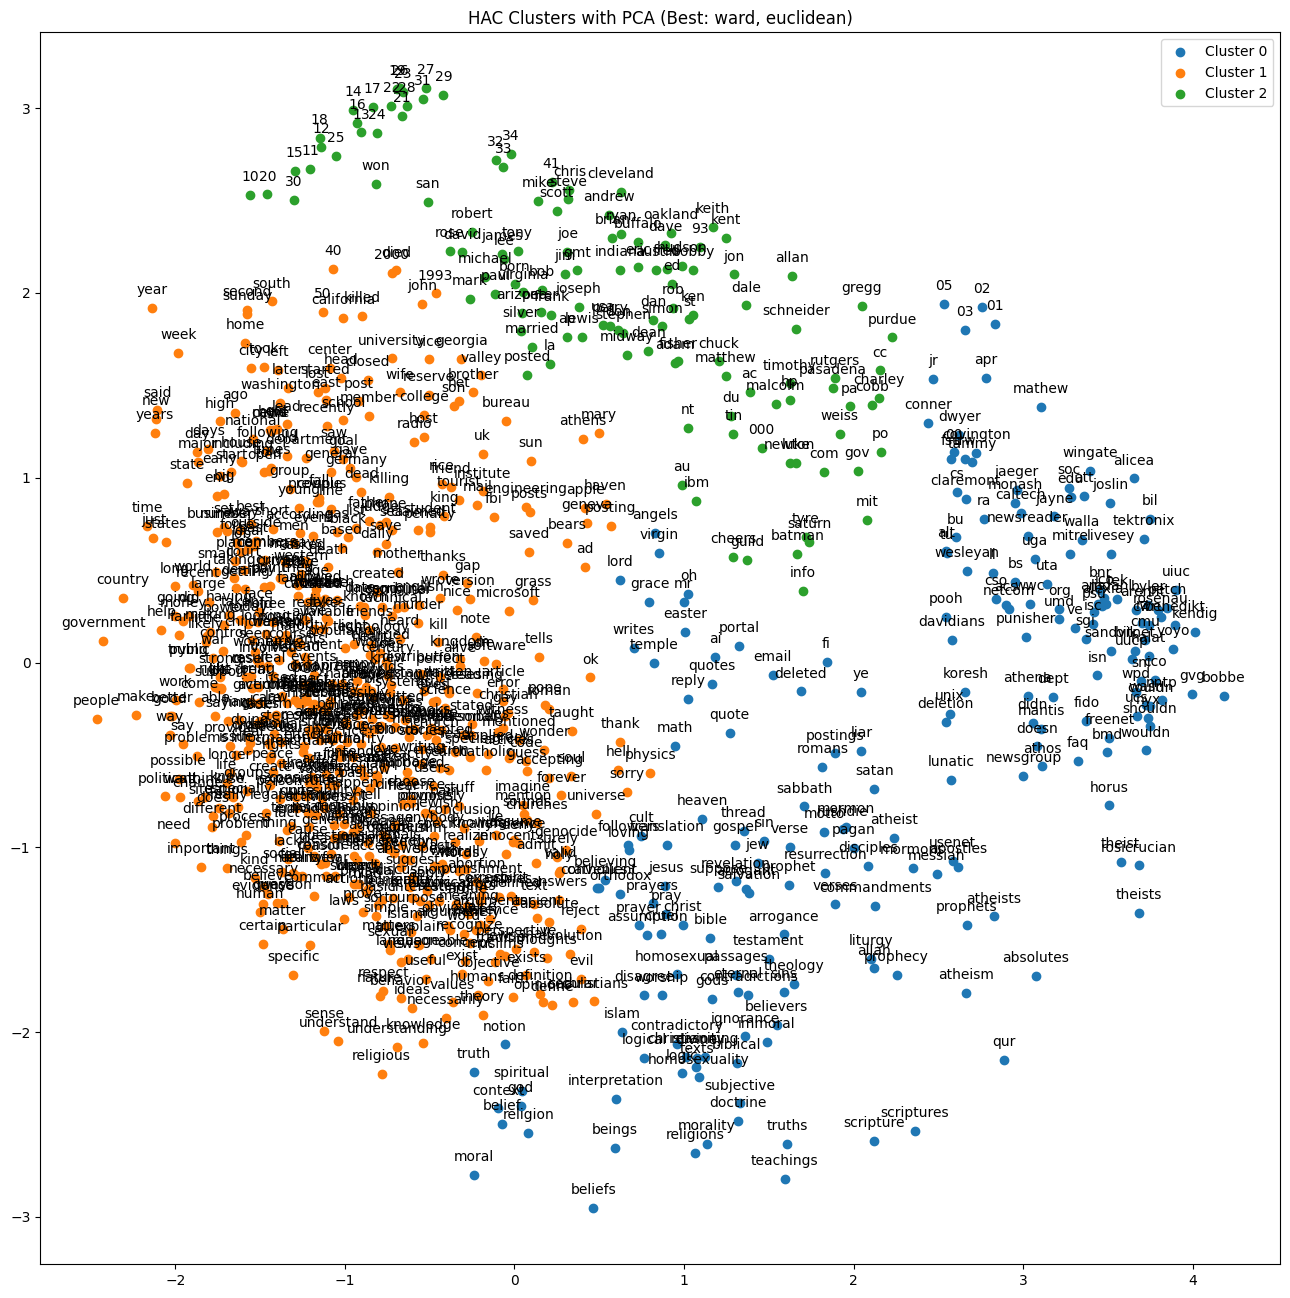

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Define different linkage and affinity options to try
linkage_options = ['ward', 'complete', 'average', 'single']
affinity_options = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']

# Best silhouette score init
best_silhouette_score = -1
best_clusters = None
best_linkage = None
best_affinity = None

for linkage in linkage_options:
    for affinity in affinity_options:
        # Skip incompatible combinations
        if linkage == 'ward' and affinity != 'euclidean':
            continue

        # Perform HAC clustering with the current set of parameters
        hac = AgglomerativeClustering(n_clusters=3, affinity=affinity, linkage=linkage)
        clusters_hac_pca = hac.fit_predict(word_vectors_pca)

        # Calculate silhouette score
        silhouette_hac_pca = silhouette_score(word_vectors_pca, clusters_hac_pca)
        print(f"Silhouette Score for HAC with PCA using {linkage} linkage and {affinity} affinity: {silhouette_hac_pca}")

        # Check if this is the best score so far and update best parameters
        if silhouette_hac_pca > best_silhouette_score:
            best_silhouette_score = silhouette_hac_pca
            best_clusters = clusters_hac_pca
            best_linkage = linkage
            best_affinity = affinity

# Function to plot the clusters
def plot_clusters(word_vectors, clusters, feature_names, title):
    plt.figure(figsize=(16, 16))
    plt.title(title)
    unique_clusters = set(clusters)
    for cluster in unique_clusters:
        cluster_idx = [i for i, c in enumerate(clusters) if c == cluster]
        cluster_points = word_vectors[cluster_idx, :]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
        for i, idx in enumerate(cluster_idx):
            if idx < len(feature_names):
                plt.annotate(feature_names[idx],
                             (cluster_points[i, 0], cluster_points[i, 1]),
                             textcoords='offset points', xytext=(0,10), ha='center')
    plt.legend()
    plt.show()

# Plot clusters with the best parameters found
if best_clusters is not None:
    print(f"Best Silhouette Score for HAC with PCA: {best_silhouette_score}")
    print(f"Best parameters - Linkage: {best_linkage}, Affinity: {best_affinity}")
    plot_clusters(word_vectors_pca, best_clusters, filtered_feature_names, f"HAC Clusters with PCA (Best: {best_linkage}, {best_affinity})")


# Results of Fine-Tuning Hierarchical Agglomerative Clustering (HAC)

Our exploration of different linkage and affinity combinations in HAC with PCA-reduced word vectors yielded varied silhouette scores. These scores provide insights into how well each configuration separates the data into distinct clusters.

## Silhouette Scores Overview

The silhouette scores for each configuration are as follows:

- Highest score achieved with **ward linkage and euclidean affinity**: `0.4351`.
- Scores with **complete linkage** varied depending on the affinity, with the highest being `0.3509` for both euclidean and l2 affinity, and the lowest being `0.2744` for l1 and manhattan affinity.
- **Average linkage** configurations also showed variation, with the highest score of `0.4249` for euclidean and l2 affinity.
- **Single linkage** consistently yielded lower scores, irrespective of the affinity used, indicating less effective clustering with this linkage method.

## Interpretation of Results

- **Ward Linkage with Euclidean Affinity**: This combination provided the highest silhouette score (`0.4351`), indicating the best-defined and most distinct clustering. This suggests that in our PCA-reduced space, the ward linkage method, which minimizes the variance within clusters, combined with the standard euclidean distance, effectively captures the inherent groupings in the data.

- **Other Linkage Methods**: The complete and average linkage methods produced moderate scores, suggesting reasonably good but not optimal clustering. The single linkage method, which tends to produce elongated, "chain-like" clusters, did not perform well, as indicated by its lower scores.

- **Affinity Choices**: The choice of affinity, while it did affect the scores, seemed secondary to the choice of linkage method. Euclidean affinity, being the standard distance measure, generally performed well across different linkage methods.

## Conclusion

The best clustering performance, as indicated by the silhouette score, was achieved using HAC with ward linkage and euclidean affinity. This configuration's ability to create well-separated and internally cohesive clusters makes it the most suitable choice for our dataset. The PCA reduction, combined with this clustering approach, appears to effectively capture and separate the underlying thematic structures present in the newsgroup text data.



# What are the major clustering in the different newsgroups? Please summarize them for each of the three newgroups.

## Summary of Clustering Analysis Across Newsgroups

The visualization of HAC with PCA shows the distribution of topics across three merged newsgroup categories. The clustering reveals how discussions from 'talk.religion.misc', 'alt.atheism', and 'soc.religion.christian' intermingle and form distinct clusters. Here is a breakdown of the major themes within each cluster:

## Cluster 0 (Blue)
This cluster appears to concentrate on foundational religious topics and doctrines. Keywords such as "bible," "christian," "faith," and "doctrine" suggest discussions rooted in Christian teachings and theological study. The presence of terms like "church" and "teachings" alongside various religious figures' names indicates a focus on organized religion and its practices.

## Cluster 1 (Orange)
The dominant themes in this cluster seem to revolve around debate and discourse, as indicated by words like "argument," "evidence," "moral," and "truth." This cluster might represent a crossover space where secular and religious perspectives meet to discuss the broader implications of belief systems. The mixture of terms like "atheism," "god," and "belief" alongside "ethics" and "critique" points to a rich dialogue concerning the intersection of religion with personal and societal values.

## Cluster 2 (Green)
This cluster is characterized by more diverse and possibly contentious topics, as suggested by words like "freedom," "rights," "law," and "issue." It could be indicative of discussions that are not purely theological but touch upon the impact of religion on public life, human rights, and social issues. The presence of terms such as "government," "political," and "society" underscores the engagement with religion in the public and political spheres.

## Integrated View of the Newsgroups
The clustering illustrates that while each newsgroup has its primary focus—general religious discussion in 'talk.religion.misc', atheistic viewpoints in 'alt.atheism', and Christian-specific discourse in 'soc.religion.christian'—there are overarching themes that transcend these boundaries. The clusters show that discussions around religion, whether affirming or critical, often converge around core topics of morality, societal norms, and the search for truth.

It's evident that the conversations across these newsgroups, while starting from different points of view, engage in a larger dialogue about the role and impact of religion in individual lives and society at large. The clustering not only separates these discussions into coherent groups but also highlights the common threads that weave through the fabric of the religious and secular discourse captured in these forums.


# How do the three newsgroups differ? How are they the same?

## Comparative Analysis of Newsgroups

The clustering analysis of the combined newsgroups has provided a visual and statistical means to discern the differences and similarities between the discussions in each forum.

## Differences Between Newsgroups

The newsgroups differ primarily in the central focus of their discussions:

- **'talk.religion.misc'** may have a broader range of topics, likely to include various religious beliefs and practices beyond Christianity. This can lead to a more eclectic mix of discussions, from religious news to philosophical debates about the existence of deities.
- **'alt.atheism'** is characterized by discussions that often challenge religious beliefs, centering on atheism, skepticism, and secular humanism. This newsgroup is expected to have debates grounded in science, logic, and philosophical arguments against religious doctrines.
- **'soc.religion.christian'** is presumably focused on topics specific to Christianity. This could range from interpretations of biblical scripture to how Christian teachings apply to modern life, as well as community-specific concerns within Christianity.

## Commonalities Among Newsgroups

Despite their differences, the newsgroups share several common themes:

- All three forums engage in **philosophical and moral discussions** about the nature of belief, the existence of higher powers, and the moral implications of religious or non-religious life stances.
- There is a shared focus on **how beliefs interface with society**—whether this pertains to religious freedoms, the role of religion in public policy, or the influence of secularism.
- Each newsgroup, in its own way, grapples with **questions of human existence, ethics, and values**. These fundamental questions provide common ground for dialogue, even when the starting points or perspectives of the participants vary.

## Integrated Perspective

The clustering suggests that while each newsgroup originates from a distinct perspective or intent, they are part of a larger discourse on religion's role in personal identity and society. They differ in the specifics of their content but converge on the universal themes of meaning, morality, and communal life. The intersecting nature of these discussions across different belief systems underscores the integral role that religion and spirituality, or their absence, play in human culture and societal interaction.


# PCA - HDBScan

<ipython-input-18-89ec6d0d74cf>:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('viridis', len(np.unique(clusters)))


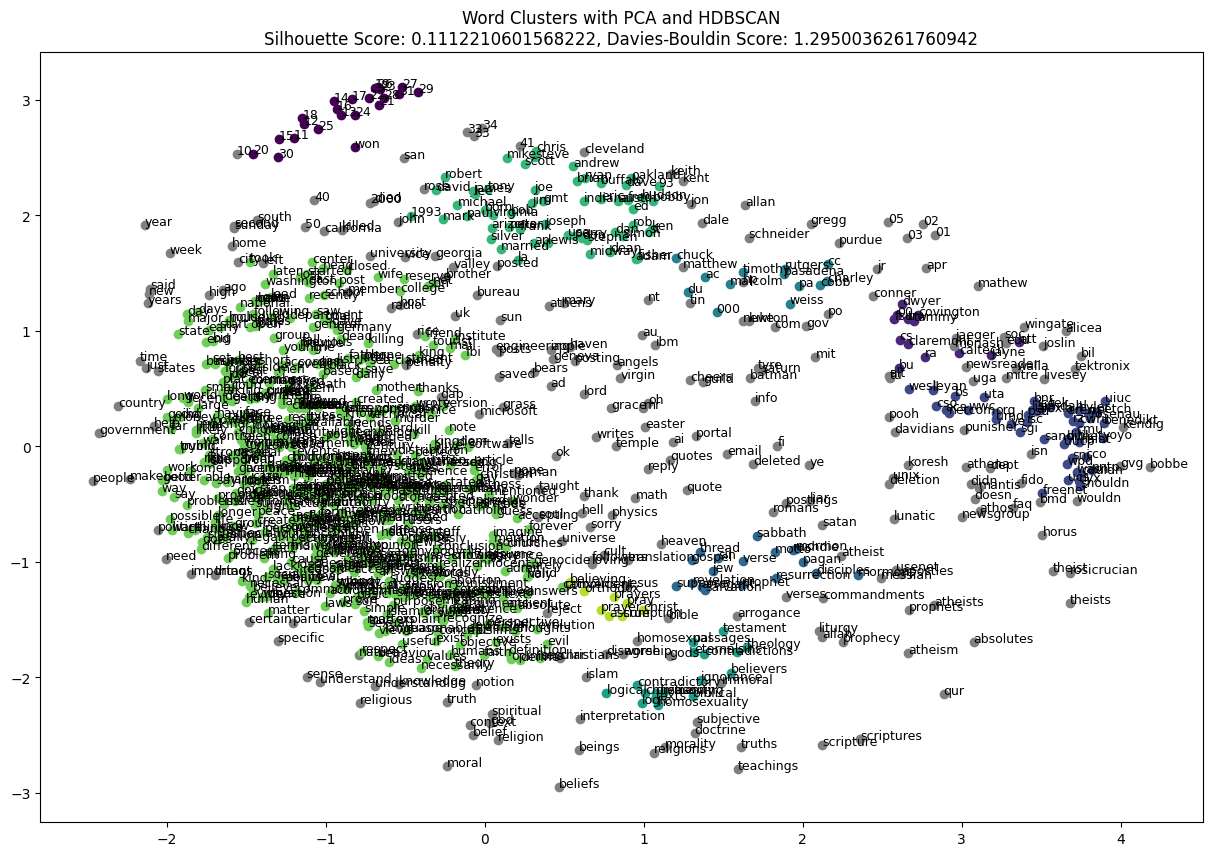

In [ ]:
!pip install hdbscan
import numpy as np
import matplotlib.pyplot as plt
import hdbscan
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Step 1: Apply PCA for dimensionality reduction
pca = PCA(n_components=2)  # reduce to 2 dimensions for visualization
reduced_vectors = pca.fit_transform(word_vectors)

# Step 2: Use HDBSCAN for clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusters = clusterer.fit_predict(reduced_vectors)

# Calculating the Silhouette and Davies-Bouldin scores
try:
    silhouette_avg = silhouette_score(reduced_vectors, clusters)
    davies_bouldin_avg = davies_bouldin_score(reduced_vectors, clusters)
except ValueError:
    silhouette_avg = None
    davies_bouldin_avg = None

# Step 3: Visualize the clusters with words
plt.figure(figsize=(15, 10))

# Generating a color palette and a color for noise points
palette = plt.cm.get_cmap('viridis', len(np.unique(clusters)))
colors = [palette(x) if x >= 0 else (0.5, 0.5, 0.5) for x in clusters]  # Grey for noise points

for i, word in enumerate(filtered_feature_names):
    plt.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1], color=colors[i])
    plt.text(reduced_vectors[i, 0], reduced_vectors[i, 1], word, fontsize=9)
plt.title(f"Word Clusters with PCA and HDBSCAN\nSilhouette Score: {silhouette_avg}, Davies-Bouldin Score: {davies_bouldin_avg}")
plt.show()



Silhouette Score: 0.2048996090888977
Davies-Bouldin Score: 1.3685972354364944


<ipython-input-19-e7411d04a86e>:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('viridis', len(np.unique(clusters)))


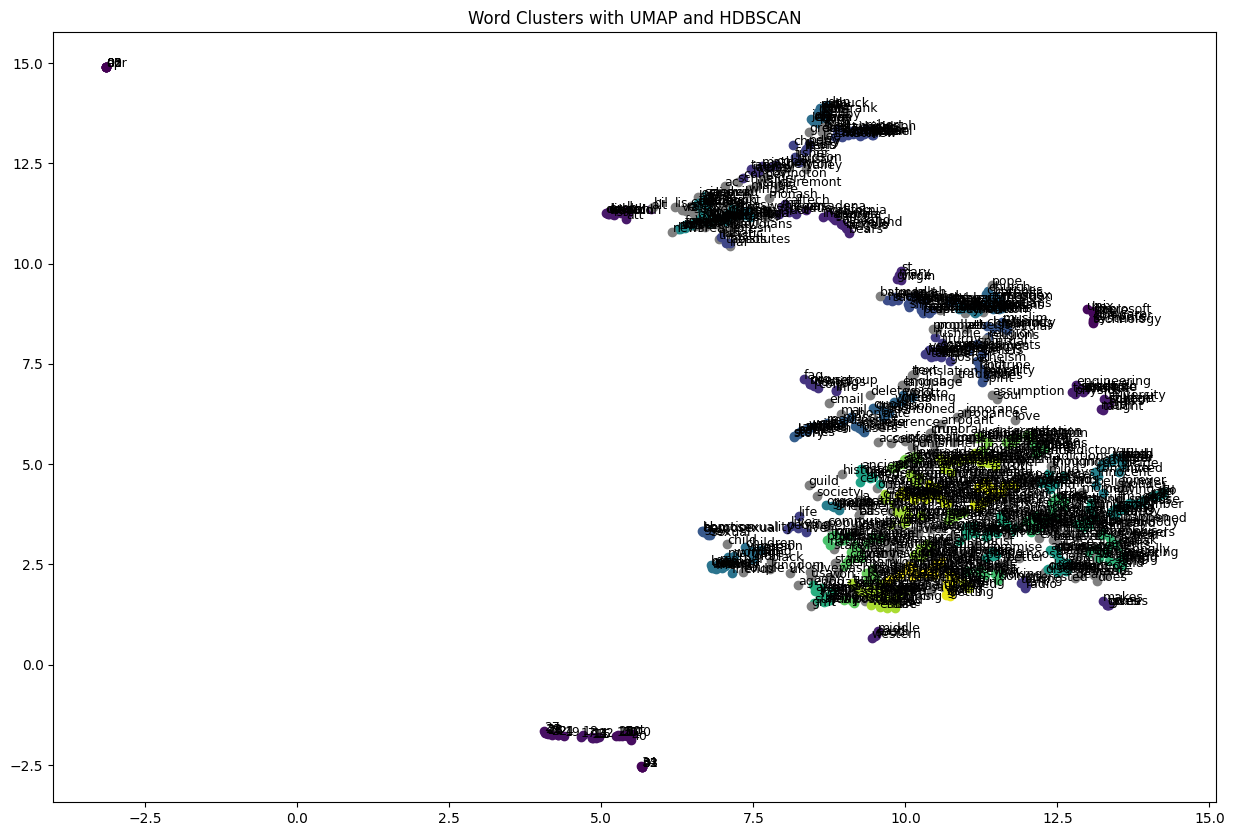

In [ ]:
!pip install umap-learn
import numpy as np
import umap
import hdbscan
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Assuming 'word_vectors' and 'filtered_feature_names' are defined as per your existing code

# Step 1: Apply UMAP for dimensionality reduction
umap_reducer = umap.UMAP(n_neighbors=5, min_dist=0.1, n_components=2)
reduced_vectors = umap_reducer.fit_transform(word_vectors)

# Step 2: Use HDBSCAN for clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, gen_min_span_tree=True)  # Adjust parameters as needed
clusters = clusterer.fit_predict(reduced_vectors)

# Step 3: Evaluate the Cluster Quality
# Note: Silhouette score may not be as meaningful for HDBSCAN due to noise points
try:
    silhouette_avg = silhouette_score(reduced_vectors, clusters)
    davies_bouldin_avg = davies_bouldin_score(reduced_vectors, clusters)
    print(f"Silhouette Score: {silhouette_avg}")
    print(f"Davies-Bouldin Score: {davies_bouldin_avg}")
except ValueError:
    print("Silhouette or Davies-Bouldin Score could not be calculated due to noise points.")

# Step 4: Visualize the clusters with words
plt.figure(figsize=(15, 10))

# Generating a color palette and a color for noise points
palette = plt.cm.get_cmap('viridis', len(np.unique(clusters)))
colors = [palette(x) if x >= 0 else (0.5, 0.5, 0.5) for x in clusters]  # Grey for noise points

for i, word in enumerate(filtered_feature_names):
    plt.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1], color=colors[i])
    plt.text(reduced_vectors[i, 0], reduced_vectors[i, 1], word, fontsize=9)
plt.title("Word Clusters with UMAP and HDBSCAN")
plt.show()


# PCA - KMeans

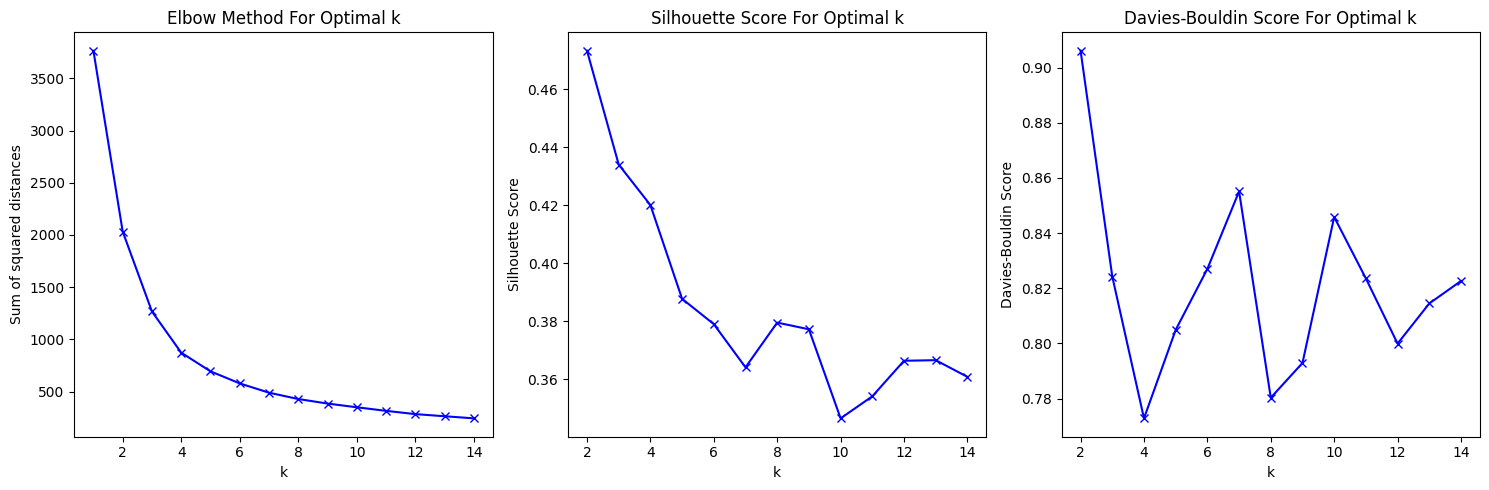

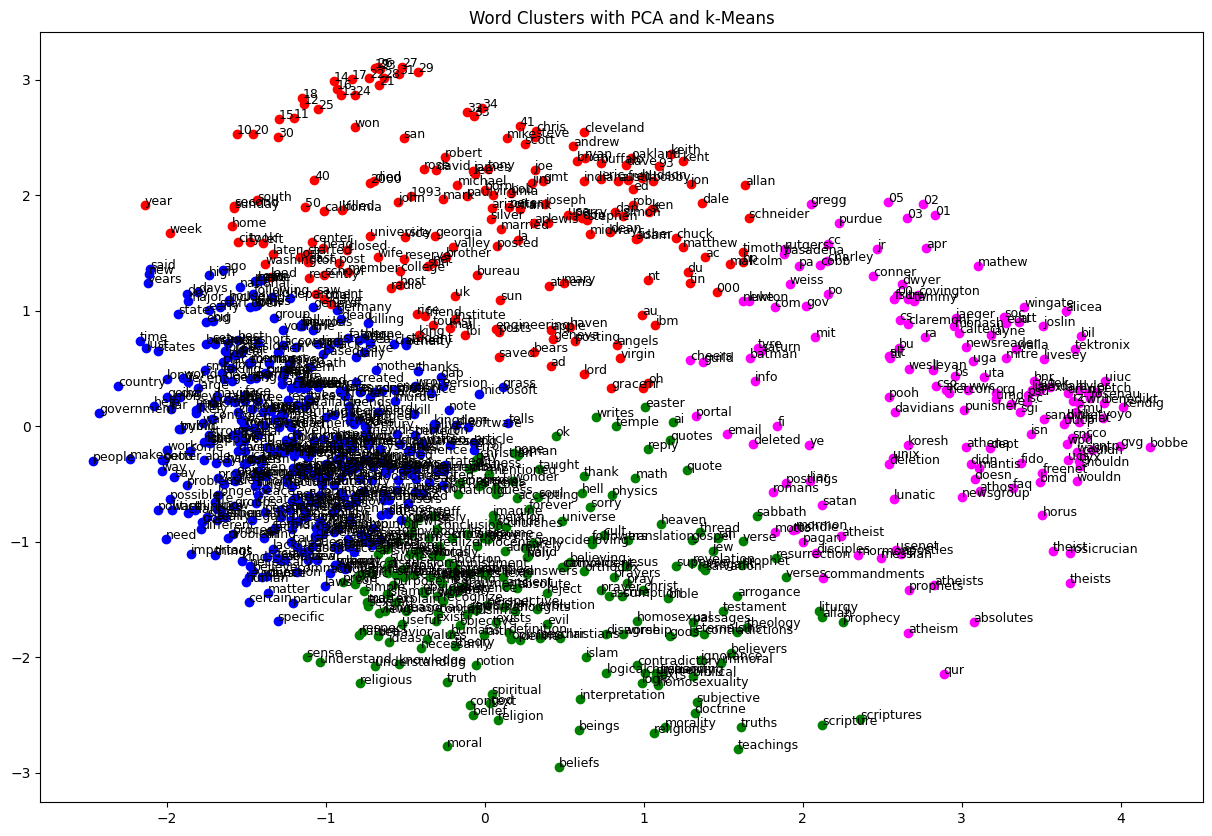

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming 'word_vectors' contains your GloVe word embeddings as per your existing code

# Step 1: Apply PCA for dimensionality reduction
pca = PCA(n_components=2)  # reduce to 2 dimensions for visualization
reduced_vectors = pca.fit_transform(word_vectors)

# Step 2: Use k-Means for clustering
kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit_predict(reduced_vectors)

# Step 3: Evaluating the Cluster
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Assuming 'reduced_vectors' is already defined and contains the reduced word vectors

# Parameters for the range of k
K = range(1, 15)

# Lists to store the metrics
Sum_of_squared_distances = []
silhouette_scores = []
db_scores = []

# Calculating metrics for each k
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(reduced_vectors)

    # Sum of squared distances
    if k > 1:  # Silhouette score and Davies-Bouldin Score are not defined for k=1
        labels = km.labels_
        silhouette_scores.append(silhouette_score(reduced_vectors, labels))
        db_scores.append(davies_bouldin_score(reduced_vectors, labels))

    Sum_of_squared_distances.append(km.inertia_)

# Creating side by side plots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Elbow Method plot
axs[0].plot(K, Sum_of_squared_distances, 'bx-')
axs[0].set_xlabel('k')
axs[0].set_ylabel('Sum of squared distances')
axs[0].set_title('Elbow Method For Optimal k')

# Silhouette Score plot
axs[1].plot(K[1:], silhouette_scores, 'bx-')  # Excluding k=1 as it's not defined
axs[1].set_xlabel('k')
axs[1].set_ylabel('Silhouette Score')
axs[1].set_title('Silhouette Score For Optimal k')

# Davies-Bouldin Score plot
axs[2].plot(K[1:], db_scores, 'bx-')  # Excluding k=1 as it's not defined
axs[2].set_xlabel('k')
axs[2].set_ylabel('Davies-Bouldin Score')
axs[2].set_title('Davies-Bouldin Score For Optimal k')

plt.tight_layout()
plt.show()

# Step 4: Visualize the clusters with words
plt.figure(figsize=(15, 10))
colors = ['red', 'green', 'blue', 'magenta']

for i, word in enumerate(filtered_feature_names):
    plt.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1], color=colors[clusters[i]])
    plt.text(reduced_vectors[i, 0], reduced_vectors[i, 1], word, fontsize=9)
plt.title("Word Clusters with PCA and k-Means")
plt.show()


# PCA - HAC

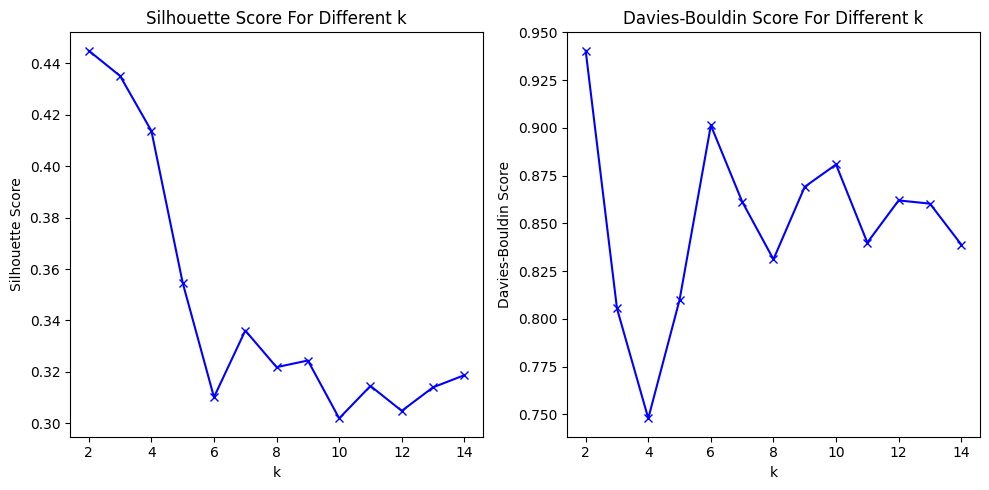

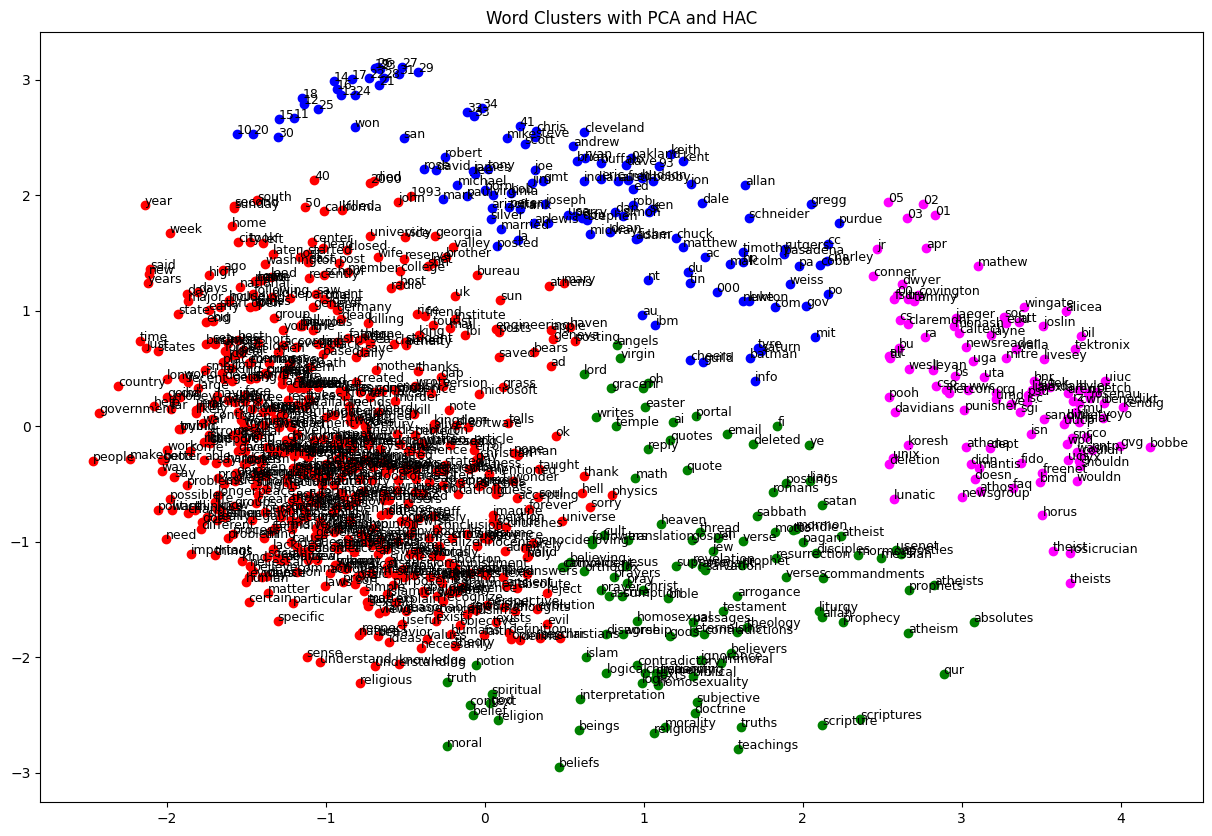

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Assuming 'word_vectors' and 'filtered_feature_names' are defined as per your existing code

# Step 1: Apply PCA for dimensionality reduction
pca = PCA(n_components=2)  # reduce to 2 dimensions for visualization
reduced_vectors = pca.fit_transform(word_vectors)

# Step 2: Use Hierarchical Agglomerative Clustering
n_clusters = 4  # Adjust based on your requirement
hac = AgglomerativeClustering(n_clusters=n_clusters)
clusters = hac.fit_predict(reduced_vectors)

# Step 3: Evaluate the Cluster Quality
# Note: HAC does not have an inertia_ attribute, so we skip the Elbow Method
silhouette_scores = []
davies_bouldin_scores = []

for k in range(2, 15):
    hac = AgglomerativeClustering(n_clusters=k)
    labels = hac.fit_predict(reduced_vectors)

    silhouette_scores.append(silhouette_score(reduced_vectors, labels))
    davies_bouldin_scores.append(davies_bouldin_score(reduced_vectors, labels))

# Plotting Silhouette and Davies-Bouldin Scores
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Silhouette Score plot
axs[0].plot(range(2, 15), silhouette_scores, 'bx-')
axs[0].set_xlabel('k')
axs[0].set_ylabel('Silhouette Score')
axs[0].set_title('Silhouette Score For Different k')

# Davies-Bouldin Score plot
axs[1].plot(range(2, 15), davies_bouldin_scores, 'bx-')
axs[1].set_xlabel('k')
axs[1].set_ylabel('Davies-Bouldin Score')
axs[1].set_title('Davies-Bouldin Score For Different k')

plt.tight_layout()
plt.show()

# Step 4: Visualize the clusters with words
plt.figure(figsize=(15, 10))
colors = ['red', 'green', 'blue', 'magenta', 'cyan', 'yellow', 'black', 'orange']  # Extend colors if needed

for i, word in enumerate(filtered_feature_names):
    plt.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1], color=colors[clusters[i] % len(colors)])
    plt.text(reduced_vectors[i, 0], reduced_vectors[i, 1], word, fontsize=9)
plt.title("Word Clusters with PCA and HAC")
plt.show()
